# test case generation

In [1]:
# create a list of parameters for velcro to generate oneshot_expert_traj
import numpy as np
from math import pi
import pickle

thetax = pi/4 * np.arange(-1, 1.01, 1/2)
thetay = pi/4 * np.arange(-1, 1.01, 1/2)
thetaz = pi * np.arange(-1, 1, 1/2)
transx = 0.3 * np.array([-1, 0, 1])
transy = 0.3 * np.array([-1, 0, 1])
radius = np.array([.6, .7, .8, .9])

n_thetax = thetax.shape[0]
n_thetay = thetay.shape[0]
n_thetaz = thetaz.shape[0]
n_transx = transx.shape[0]
n_transy = transy.shape[0]
n_radius = radius.shape[0]

n_flat = n_thetaz * n_thetax * n_thetay * n_transx * n_transy * 1
flat_params = [['flat'] for i in range(n_flat)]

eulers = []
for i in range(n_thetax):
    for j in range(n_thetay):
        for k in range(n_thetaz):
            eulers.append([thetax[i], thetay[j], thetaz[k]])

offsets = []
for i in range(n_transx):
    for j in range(n_transy):
        offsets.append([transx[i], transy[j], 0.])

n_theta = n_thetax * n_thetay * n_thetaz
n_offset = n_transx * n_transy
for i in range(n_theta):
    for j in range(n_offset):
        flat_params[j+i*n_offset].append(offsets[j])
        flat_params[j+i*n_offset].append(eulers[i])
        flat_params[j+i*n_offset].append(10.)
        
n_cyln = n_thetaz * n_thetax * n_thetay * n_transx * n_transy * n_radius
cyln_params = [['cylinder'] for i in range(n_cyln)]
for i in range(n_theta):
    for j in range(n_offset):
        for k in range(n_radius):
            idx = k + j * n_radius + i * n_radius * n_offset
            cyln_params[idx].append(offsets[j])
            cyln_params[idx].append(eulers[i])
            cyln_params[idx].append(radius[k])

velcro_params = flat_params + cyln_params

In [2]:
print(len(velcro_params))
with open('/home/jc/research/corl2019_learningHaptics/models/uniform_sample.pkl', 'wb') as f:
    pickle.dump(velcro_params, f)
    f.close()

4500


In [5]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

num = 3000
DIR = '/home/jc/logs/vision_data/'
csv_file = open(DIR + 'test.csv', 'a')

for n in range(5,6):
    traj_path = DIR + 'exp_traj_{}.pkl'.format(n)
    with open(traj_path, 'rb') as f:
        traj = pickle.load(f)
        f.close()
        t = traj['traj']
    print(len(t))
    for i, item in enumerate(t):
        for j in range(len(item)):
            num += 1
            img = item[j]['image']
            norm = item[j]['norm']
            center = item[j]['center']
            gpos = item[j]['gpos']
            fl_center = center[:3]
            fl_norm = norm[:3]
            break_dir_norm = norm[6:9]
            label = np.concatenate((fl_center, fl_norm, break_dir_norm, gpos), axis=None)
            np.save(DIR + 'images/img_{}.npy'.format(num), img)
            np.save(DIR + 'labels/label_{}.npy'.format(num), label)
            csv_file.write('img_{}.npy,label_{}.npy\n'.format(num, num))
            
csv_file.close()

97


In [6]:
print(num)
# data_frame = pd.read_csv('/home/jc/logs/vision_data/train.csv')

3671


In [9]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import numpy as np
import torch
import os

class VisionInputDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, 'images',
                                self.data_frame.iloc[idx, 0])
        label_name = os.path.join(self.root_dir, 'labels',
                                self.data_frame.iloc[idx, 1])
        image = np.load(img_name)
        label = np.load(label_name)
        sample = {'image': image, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample

# Theta peel tactile data extraction from real robot

In [90]:
import pickle as pkl
import numpy as np
def load_txt(path):
    file = open(path, 'r')
    result = []
    for line in file:
        result.append(line.rstrip())
    return result

def timestamp(time_txt):
    '''
    time text is in format hour:min:sec,millisec

    '''
    millisec = time_txt.split(',')[1]
    hour, minute, second = time_txt.split(',')[0].split(':')
    return float(hour) * 3600 + float(minute) * 60 + float(second) + float(millisec) * 1e-7

def pose_str2list(str):
    pose = str.split(',')
    pose = [float(item) for item in pose]
    return pose

def extrat_force(txt):
    result = []
    for i, line in enumerate(txt):
        try:
            items = line.split()
            time = timestamp(items[2])
            fx = float(items[4].split(',')[0])
            fy = float(items[5].split(',')[0])
            fz = float(items[6])
            result.append([time, fx, fy, fz])
        except:
            print(i)
    return result

def extrat_traj(txt):
    n = len(txt)
    result = []
    for i in range(0, n, 5):
        theta = float(txt[i].split('theta: ')[1])
        t_start = timestamp(txt[i+1].split()[2])
        t_end = timestamp(txt[i+3].split()[2])
        p_start = pose_str2list(txt[i+2].split('position: ')[1][1:-1])
        p_end = pose_str2list(txt[i+4].split('position: ')[1][1:-1])
        result.append([theta, t_start, t_end, p_start, p_end])
    return result

def sort_force(force, traj):
    sorted_forces = []
    for item in traj:
        sorted_force = []
        for line in force:
            t_force = line[0]
            t_traj_start = item[1]
            t_traj_end = item[2]
            if t_force > t_traj_start and t_force < t_traj_end:
                sorted_force.append(line)
        sorted_forces.append(sorted_force)
    return sorted_forces

def interpolate(force, traj):
    assert len(force) == len(traj)
    result = []
    for i, item in enumerate(force):
        n = len(item)
        y_start = traj[i][3][1]
        y_end   = traj[i][4][1]
        z_start = traj[i][3][2]
        z_end   = traj[i][4][2]
        stepy   = (y_end - y_start) / (n-1)
        stepz   = (z_end - z_start) / (n-1)
        Y = np.arange(y_start, y_end+stepy, stepy)
        Z = np.arange(z_start, z_end+stepz, stepz)
        
        if Y.shape[0] > n:
            Y = Y[:n]
        if Z.shape[0] > n:
            Z = Z[:n]
#         print(traj[i])
#         print(n, Z.shape[0], Y.shape[0])
#         print(Z)
        assert Y.shape[0] == n
        assert Z.shape[0] == n
        
        result.append([Y,Z])
    return result
        
for i in range(3):
    traj_path  = '/home/jc/logs/realrobot/thetapeel_{}.txt'.format(i)
    force_path = '/home/jc/logs/realrobot/force_1.txt'
    save_path = '/home/jc/logs/realrobot/traj_{}.pkl'.format(i)

    traj_txt = load_txt(traj_path)
    force_txt = load_txt(force_path)

    force = extrat_force(force_txt)
    traj = extrat_traj(traj_txt)
    sorted_forces = sort_force(force, traj)
    inter_traj = interpolate(sorted_forces, traj)
    print(len(inter_traj[1]))

    with open(save_path, 'wb') as f:
        pkl.dump([inter_traj, sorted_forces], f)
        f.close()

17263
2
17263
2
17263
2


In [91]:
i = 2
print(traj[i])
print(inter_traj[i])
print(sorted_forces[i])

[60.0, 57378.0544078, 57383.0635355, [0.35094988346099854, 0.09895552694797516, 0.020940057933330536], [0.35096344351768494, 0.11400666832923889, 0.04694729298353195]]
[array([0.09895553, 0.09924497, 0.09953442, 0.09982386, 0.10011331,
       0.10040275, 0.1006922 , 0.10098164, 0.10127109, 0.10156053,
       0.10184998, 0.10213942, 0.10242887, 0.10271831, 0.10300776,
       0.1032972 , 0.10358665, 0.10387609, 0.10416554, 0.10445498,
       0.10474443, 0.10503387, 0.10532332, 0.10561276, 0.10590221,
       0.10619165, 0.1064811 , 0.10677054, 0.10705999, 0.10734943,
       0.10763888, 0.10792832, 0.10821777, 0.10850721, 0.10879666,
       0.1090861 , 0.10937555, 0.10966499, 0.10995444, 0.11024388,
       0.11053333, 0.11082277, 0.11111222, 0.11140166, 0.11169111,
       0.11198055, 0.11227   , 0.11255944, 0.11284889, 0.11313833,
       0.11342778, 0.11371722, 0.11400667]), array([0.02094006, 0.0214402 , 0.02194034, 0.02244048, 0.02294061,
       0.02344075, 0.02394089, 0.02444103, 0.0249

In [100]:
# plot the tactile feedbacks and save figs
import numpy.linalg as la
import matplotlib.pyplot as plt

y_offset = [0.014, 0.05, 0.099]
num_tests = 3
N = 9
fig_dir = '/home/jc/logs/realrobot/'
fig, axe = plt.subplots(1, 1)
max_force = 0
for i in range(num_tests):
    with open('/home/jc/logs/realrobot/traj_{}.pkl'.format(i), 'rb') as file:
        result = pkl.load(file)
        
    traj, force = result
    
    num_traj = len(force)
    for k in range(num_traj):
        Y,Z = traj[k]
        for j, f in enumerate(force[k]):
            if la.norm(np.array(f[1:])) > max_force:
                max_force = la.norm(np.array(f[1:]))
            color = la.norm(np.array(f[1:])) / 22
            axe.plot(-Y[j]+y_offset[i], Z[j], marker='.', color=(1, 0, 0, color))
    axe.set_xlabel('y (m)')
    axe.set_ylabel('z (m)')
#     cbar = fig.colorbar(ax=axe)
    fig.savefig(fig_dir+'num{}.png'.format(i), format='png')
    axe.cla()
plt.close(fig)
print(max_force)

21.066308195789787


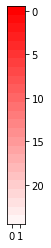

In [117]:
# plot color bar
n = 25
m = 2
a = np.zeros((n,m,4))
for i in range(n):
    for j in range(m):
        a[i,j,:] = np.array([1, 0,0, 1-float(i)/n])
f = plt.figure()

ax = f.add_subplot(111)
ax.yaxis.tick_right()
ax.invert_yaxis()
# ax.set_ylim(ax.get_ylim()[:-1:])
ax.imshow(a)

# pytorch vision dataset dataloader test

6849
0 [ 0.04612154 -0.16381945 -0.17078317  0.38846018  0.59470314 -0.70386566
 -0.31169673 -0.634022   -0.70771552 -0.1799353  -0.34267369 -2.44223713]
1 [ 0.01544264 -0.21925363 -0.2345516   0.38846018  0.59470314 -0.70386566
 -0.47775783 -0.5231801  -0.70571243  0.02618038 -0.35181522 -2.25536538]
2 [-0.00575539 -0.21740644 -0.24469     0.38846018  0.59470314 -0.70386566
 -0.32239365 -0.62786225 -0.70841466 -0.20448065 -0.2152068  -2.33443973]
3 [-0.00575539 -0.21740644 -0.24469     0.38846018  0.59470314 -0.70386566
 -0.32239365 -0.62786225 -0.70841466 -0.20662627 -0.08659741 -2.5577814 ]


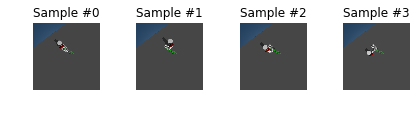

In [10]:
vision_dataset = VisionInputDataset('/home/jc/logs/vision_data/test.csv', '/home/jc/logs/vision_data/')

print(len(vision_dataset))
for i in range(len(vision_dataset)):
    sample = vision_dataset[i]

    print(i, sample['label'])

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    img = sample['image'].transpose(1,2,0)[:,:,:3]
    ax.imshow(img)

    if i == 3:
        plt.show()
        break
        
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        return {'image': torch.from_numpy(image),
                'label': torch.from_numpy(label)}

In [13]:
torch_dataset = VisionInputDataset(csv_file='/home/jc/logs/vision_data/test.csv', 
                                    root_dir='/home/jc/logs/vision_data/',
                                    transform=transforms.Compose([
                                               ToTensor()
                                           ]))

In [14]:
for i in range(len(torch_dataset)):
    sample = torch_dataset[i]

    print(i, sample['image'].size(), sample['label'].size())

    if i == 3:
        break

0 torch.Size([4, 250, 250]) torch.Size([12])
1 torch.Size([4, 250, 250]) torch.Size([12])
2 torch.Size([4, 250, 250]) torch.Size([12])
3 torch.Size([4, 250, 250]) torch.Size([12])


In [23]:
dataloader = DataLoader(torch_dataset, batch_size=4,
                        shuffle=True, num_workers=4)

# Plot training results

3000
3000


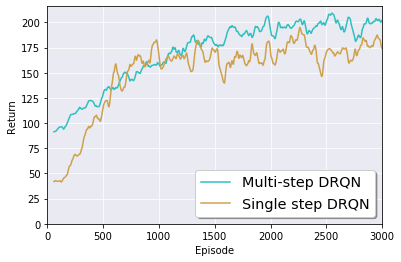

In [19]:
import numpy as np
import pickle
import argparse
import scipy.ndimage as sciimg
from utils.sliding_window import sliding_window_view
import matplotlib.pyplot as plt

def var_of_means(window, win_size, N):
    means = []
    for i in range(N):
        sample = []
        for j in range(win_size):
            sample.append(np.random.choice(window))
        means.append(np.average(sample))
    return np.average(window), np.std(means)

def smooth_array(array_list, sigma=5):
    result = []
    for item in array_list:
        result.append(sciimg.gaussian_filter(item, sigma=sigma, mode='reflect'))
    return result

def plot_variables(axe, plot_var, colors, label):
    rewards = np.array(plot_var['rewards'])
    rew_expand = sliding_window_view(rewards, [win_size], steps=[1])
    line_color, edge_color, face_color = colors

    M = rew_expand.shape[0]
    rm = np.empty(M)
    rub = np.empty(M)
    rlb = np.empty(M)

    for i in range(M):
        mean_r, var_r = var_of_means(rew_expand[i,:], win_size, 10)
        rm[i] = mean_r
        rub[i] = mean_r + 1.96 * var_r
        rlb[i] = mean_r - 1.96 * var_r
        
    # further smooth the data
    [rm] = smooth_array([rm], sigma = sigma)
#     [rub, rlb] = smooth_array([rub, rlb], sigma = 3*sigma)

    x = np.arange(win_size, win_size + M)

    ax.set_xlabel('Episode')
    ax.set_ylabel('Return')
    ax.plot(x, rm, line_color, label=label)
#     ax.fill_between(x, rlb, rub, alpha=1, edgecolor=edge_color, facecolor=face_color)
    ax.set_xlim(0, rewards.shape[0])
    ax.set_ylim(0, 216)
    ax.set_facecolor('#EAEAF2')
    ax.grid(color='w', b=True, which='major')

title = "No translation in initialization"
win_size =60
sigma = 4
fig, ax = plt.subplots(1, 1)
# fig.suptitle(title)

result_path = '/home/jc/logs/multistep_final/results_multistep.pkl'
with open(result_path, 'rb') as file:
    multistep = pickle.load(file)
print(len(multistep['rewards']))
for i in range(2500, 3000):
    multistep['rewards'][i] += (i-2500)/70
plot_variables(ax, multistep, ['#30BFBF', '#A7DADF', '#C4E1E7'], 'Multi-step DRQN')

result_path = '/home/jc/logs/pomdp_final/results_pomdp.pkl'
with open(result_path, 'rb') as file:
    pomdp = pickle.load(file)
print(len(pomdp['rewards']))
for i in range(2000,3000):
    pomdp['rewards'][i] -= (i-2000)/45
# color = [line, edge, face]
plot_variables(ax, pomdp, ['#CEA14B', '#BBA66E', '#F2E8CA'], 'Single step DRQN')

legend = ax.legend(loc='lower right', shadow=True, fontsize='x-large')

fig_dir = '/home/jc/phd/papers/icra2020_learningHaptics/fig/'
fig.savefig(fig_dir+'training_reward.png', format='png')

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

result_path = '/home/jc/logs/vision_baseline/results_convnet.pkl'
with open(result_path, 'rb') as file:
    directory = pickle.load(file)   
trainloss = directory['train_loss']
tl = [trainloss[i].cpu().numpy() for i in range(len(trainloss))]

In [2]:
testloss = directory['test_loss']
test = [testloss[i].numpy() for i in range(len(testloss))]

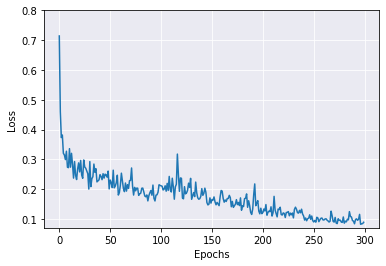

In [4]:
tl = np.stack(tl)
fig, ax = plt.subplots(1, 1)
# ax.set_yscale('log')
ax.set_ylim((0.07, 0.8))
ax.set_facecolor('#EAEAF2')
ax.grid(color='w', b=True, which='major')
ax.plot(tl)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
fig_dir = '/home/jc/phd/papers/icra2020_learningHaptics/fig/'
fig.savefig(fig_dir+'vision_loss.png', format='png')
# test = np.stack(test)
# ax.plot(test)

# evaluate collision

In [46]:
import numpy as np
import matplotlib.pyplot as plt
n = np.array([216, 216, 216, 158, 199, 216, 216, 216, 216, 216, 216, 216, 216, 216, 203, 216, 216, 216, 216, 
              157, 216, 216, 216, 164, 216, 169, 191, 130, 216, 216, 173, 148, 216, 216, 216, 216, 216, 167,
              216, 216, 61, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 159, 216, 165, 216,  216, 
              216, 216, 216, 216, 216, 216, 216, 216, 216, 109, 216, 216, 216, 216, 216, 216, 143, 216, 136,
              216, 216, 216, 216, 216, 216, 216, 160, 216, 216, 216, 216, 216, 216, 179, 167, 216, 216, 216, 
              216, 216, 216,  177, 216, 216, 216, 216, 149, 216, 132, 216, 216, 216, 216, 216, 216, 216, 216,
              216, 216, 94, 216, 216, 216, 150, 216, 216, 158, 216, 216, 216, 216, 216, 216, 216, 216, 216,
              216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 156, 216, 216, 216, 216, 206, 216, 172, 216, 
              216, 216, 157, 144, 216, 117, 216, 179, 168, 216, 216, 216, 216, 216, 216, 216, 
              216, 216, 216, 216, 216, 216, 216, 146, 192, 216, 216, 216, 216, 123,
              112, 216, 216, 185, 70, 126, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 193, 216,0, 3, 
              216, 31, 216, 216, 216, 216, 52, 11, 52, 216, 182, 216, 216, 164, 44, 216, 216, 216, 18, 216,
              216, 65, 216, 216, 94, 216, 216, 58, 216, 216, 216, 216, 216, 216, 158, 216, 77, 216, 216, 216,
              39, 96, 96, 48, 160, 216, 154, 89, 216, 216, 216, 216, 216, 216, 216, 62, 216, 216, 216, 216, 
              18, 216, 216, 216, 101, 216, 216, 216, 216, 216, 216, 216, 216, 146, 216, 120, 34, 216, 100, 68,
              216, 216, 168, 216, 204, 71, 216, 129, 159, 216, 216, 112, 216, 43, 216, 216, 144, 216, 216, 
              216, 216, 216, 216, 216, 216, 216, 216, 216, 42, 216, 216, 93, 216, 153, 216, 160, 216, 216, 
              216, 216, 216, 150, 216, 216, 216, 216, 216, 216, 216, 216, 216, 150, 216, 216, 216, 216, 216, 
              216, 216, 161, 216, 216, 216, 25, 216, 77, 216, 198, 216, 51, 216, 216, 216, 216, 216, 216, 216,
              216, 216, 216, 216, 216, 216, 176, 216, 216, 216, 216, 216, 150, 216, 216, 216, 216, 216, 216, 
              216, 216, 216, 118, 216, 216, 216, 216, 216, 90, 216, 111, 216, 115, 216, 216, 51, 216, 216, 
              216, 216, 216, 52, 216, 216, 114, 14, 151, 77, 216, 174, 216, 63, 138, 143, 216, 216, 192, 
              216, 216, 126, 216, 216, 216, 216, 216, 216, 216, 216, 172, 216, 216, 216, 216, 42, 216, 59, 76,
              216, 216, 216, 216, 216, 124, 114, 216, 216, 57, 216, 216, 216, 88, 216, 216, 216, 216, 200, 216, 
              118, 216, 216, 216, 89, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 
              216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 
              187, 216, 216, 216, 216, 216, 216, 216, 216, 177, 216, 216, 216, 216, 135, 216, 216, 216, 150, 
              216, 216, 216, 216, 216, 170, 216, 216, 145, 131, 216, 216, 181, 216, 79, 216, 216, 216, 216, 
              216, 181, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 171, 216,
              146, 216, 216, 216, 216, 216, 216, 216, 216, 205, 216, 216, 216, 216, 216, 216, 216, 216, 216, 
              216, 193, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 59, 216, 216, 216, 216, 216,
              216, 128, 216, 95, 216, 216, 216, 216, 216, 25, 0, 161, 216, 216, 216, 216, 216, 216, 216, 216, 216,
              216, 216, 216, 169, 165, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216,
              121, 216, 216, 216, 216, 216, 216, 216, 216, 216, 181, 216, 216, 181, 216, 216, 216, 216, 216, 216,
              216, 216, 146, 216, 216, 94, 216, 216, 216, 181, 216, 112, 216, 193, 216, 216, 216, 216, 216, 216,
              216, 216, 135, 216, 216, 216, 216, 216, 216, 154, 216, 216, 216, 216, 216, 104, 216, 216, 216, 216,
              216, 216, 146, 162, 216, 216, 216, 216, 216, 15, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216,
              216, 193, 216, 216, 216, 216, 216, 216, 216, 159, 216, 216, 216, 150, 84, 216, 216, 216, 170, 216, 
              216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 78,
              216, 216, 216, 216, 216, 216, 216, 104, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216,
              216, 216, 216, 216, 63, 216, 216, 216, 216, 216, 216, 216, 164, 216, 216, 120, 216, 216, 216, 172, 
              216, 70, 216, 216, 216, 216, 216, 216, 216,216, 216, 216, 216, 58, 216, 216, 216, 216, 216, 216, 
              216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 118, 216, 216, 216,
              216, 74, 216, 216, 216, 216, 208, 199, 216, 74, 137, 162, 189, 216, 216, 216, 216, 216, 117, 207, 
              216, 144, 216, 163, 88, 216, 216, 156, 216, 191, 216, 216, 120, 216, 216, 216, 216, 199, 216, 216,
              181, 136, 216, 216, 216, 216, 216, 216, 125, 216, 216, 216, 216, 216, 216, 216, 126, 216, 216, 216,
              216, 216, 216, 151, 85, 216, 216, 216, 216, 204, 216, 216, 216, 86, 216, 196, 167, 216, 216, 216,
              216, 216, 216, 216, 216, 216, 216, 216, 185, 169, 216, 216, 216, 216, 216, 117, 216, 216, 193, 216,
              216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 188, 97, 216, 216, 216, 216, 216, 216, 95, 
              216, 216, 216, 216, 216, 142, 177, 96, 216, 148, 171, 216, 216, 202, 216, 85, 216, 216, 216, 216, 
              216, 43, 127, 216, 175, 216, 216, 216, 216, 135, 216, 216, 216, 216, 216, 216, 207, 216, 216, 216, 
              216, 216, 216, 216, 216, 216, 216, 216, 216,216, 216, 216, 197, 216, 216, 216, 216, 216, 216, 216, 
              216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 96, 138, 216, 173, 216, 216, 216, 216, 216,
              216, 216, 116, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 155, 216, 19, 129,
              216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 114, 104, 216, 216, 216, 216, 216,
              160, 216, 216, 216, 216, 216, 216, 13, 216, 216, 168, 55, 216, 216, 146, 216, 216, 216, 216, 216,
              216, 216, 216, 216, 168, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 30, 216, 58, 216, 216,
              216, 163, 216, 216, 216, 216, 216, 216, 216, 74, 216, 216, 121, 216, 216, 216, 216, 216, 59, 77, 
              216, 216, 216, 216, 216, 216, 216, 112, 140, 216, 179, 141, 216, 216, 216, 104, 216, 216, 100, 78, 
              216, 216, 216, 216, 216, 216, 186, 216, 216, 94, 216, 216, 216, 216, 149, 216, 216, 216, 216, 216,
              216, 216, 216, 216, 68, 119, 132, 123, 216, 216, 216, 216, 216, 216, 127, 44, 216, 216, 216, 216, 
              216, 216, 216, 216, 216, 216, 216, 216, 216, 160, 216, 216, 129, 216, 216, 184, 216, 216, 216, 
              216, 121, 216, 216, 216, 131, 86, 216, 216, 216, 216, 216, 155, 216, 216, 216, 216, 216, 10, 216,
              216, 216, 216, 216, 216, 216, 216, 216, 216, 153, 9, 63, 216, 216, 206, 216, 216, 216, 216, 216, 
              98, 216, 216, 216, 216, 216, 216, 190, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 33,
              216, 216, 216, 182, 216, 103, 216, 176, 216, 216, 216, 216, 141, 30, 216, 216, 216, 127, 216, 216,
              216, 128, 216, 216, 216, 216, 216, 153, 216, 216, 216, 216, 216, 139, 216, 216, 27, 216, 216, 216,
              216, 205, 3, 216, 216, 74, 216, 216, 216, 216, 126, 216, 216, 216, 216, 8, 216, 216, 216, 216, 216, 
              216, 163, 216, 216, 216, 216, 216, 216, 216, 178, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216,
              98, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 139, 
              216, 216, 216, 216, 216, 216, 216, 6, 216, 216, 216, 216, 216, 216, 216, 216, 216, 216, 58, 216, 
              216, 60, 216, 216, 216, 216, 216, 216])
collision = np.array([0, 0, 16, 0, 13, 7, 0, 0, 0, 29, 0, 0, 0, 0, 0, 36, 0, 23, 0, 0, 0, 1, 0, 0, 0, 14,
                      0, 2, 0, 0, 0, 3, 0, 20, 12, 0, 0, 0, 0, 0, 0, 31, 4, 31, 0, 18, 0, 0, 13, 28, 0, 25, 
                      7, 0, 0, 2, 0, 10, 0, 0, 12, 0, 1, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17, 0, 6, 
                      31, 0, 0, 0, 10, 21, 6, 4, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 15, 7, 0, 0, 0, 0, 0, 0, 
                      16, 0, 17, 28, 0, 0, 21, 0, 0, 2, 0, 2, 0, 0, 4, 0, 0, 0, 3, 0, 0, 10, 0, 12, 0, 2, 0,
                      0, 0, 0, 0, 0, 18, 0, 13, 0, 0, 0, 1, 38, 0, 0, 4, 0, 0, 2, 0, 0, 0, 5, 10, 5, 0, 2, 0,
                      0, 0, 0, 1, 0, 72, 14, 0, 0, 0, 0, 0, 0, 21, 40, 5, 14, 0, 0, 12, 0, 0, 0, 0, 0, 0, 0, 
                      0, 0, 6, 0, 1, 0, 0, 38, 0, 0, 0, 0,15, 665, 1, 4447, 5, 0, 164, 417, 1430, 3493, 596,
                      0, 4079, 3, 50, 113, 173, 0, 676, 0, 6490, 100, 6, 2813, 5, 114, 55, 21, 39, 761, 62, 
                      70, 0, 0, 2088, 1, 151, 258, 13, 95, 1, 26, 4894, 4361, 716, 1153, 2104, 0, 25, 68, 
                      2914, 0, 0, 2415, 95, 0, 0, 236, 0, 0, 0, 0, 68, 10, 16, 0, 57, 1, 2, 0, 25, 61, 31,
                      0, 1, 0, 0, 2186, 3641, 95, 1309, 1030, 0, 1, 13, 47, 94, 183, 183, 688, 649, 134, 0, 
                      102, 12, 916, 0, 8, 24, 4, 0, 1, 21, 0, 12, 91, 0, 37, 31, 4, 153, 0, 13, 0, 0, 7, 64,
                      67, 19, 34, 0, 588, 1, 109, 31, 0, 0, 5, 0, 1615, 0, 0, 0, 5, 181, 0, 0, 0, 4, 149, 0,
                      1607, 0, 0, 1, 332, 10, 3, 34, 11, 49, 626, 218, 11, 1, 11, 0, 253, 491, 0, 0, 0, 0, 0, 
                      0, 114, 1, 1, 0, 139, 0, 1319, 0, 0, 0, 1, 175, 0, 0, 281, 0, 317, 6, 64, 6, 0, 0, 4300,
                      23, 135, 0, 1312, 0, 3, 1215, 245, 8, 0, 3, 54, 1811, 235, 532, 51, 2749, 87, 21, 0, 60,
                      97, 289, 0, 163, 0, 17, 1868, 0, 0, 0, 0, 0, 0, 47, 1, 0, 60, 1, 0, 1, 358, 1, 359, 347,
                      1603, 2321, 508, 204, 1, 36, 7, 0, 13, 5, 20, 0, 85, 0, 0, 0, 166, 1, 0, 0, 0, 518, 1, 1675,
                      0, 475, 35, 33, 89, 0, 1, 212, 0, 27, 0, 2, 0, 0, 0, 1, 0, 131, 0, 0, 0, 50, 0, 42, 136,
                      0, 0, 466, 0, 0, 1, 1334, 1, 0, 0, 42, 0, 140, 9, 0, 0, 0, 1, 7, 19, 779, 142, 20, 4, 0, 
                      11, 38, 0, 0, 0, 199, 0, 0, 34, 13, 245, 382, 0, 1, 36, 2092, 158, 25, 2599, 0, 776, 0, 41,
                      0, 34, 258, 64, 0, 0, 43, 0, 105, 45, 4, 218, 0, 25, 20, 0, 0, 1, 0, 12, 0, 506, 0, 282, 
                      19, 0, 1, 1, 0, 0, 244, 1, 0, 0, 0, 0, 14, 23, 1, 0, 1, 3, 0, 14, 0, 0, 0, 0, 3, 80, 52, 
                      180, 27, 28, 639, 1, 0, 116, 64, 0, 0, 126, 56, 979, 1, 637, 20, 0, 795, 609, 418, 0, 0, 
                      7, 0, 0, 31, 16, 6, 0, 0, 9, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20, 3, 0, 0, 0, 0, 0, 0, 0, 0, 
                      0, 0, 7, 63, 0, 0, 0, 0, 0, 28, 0, 0, 0, 0, 0, 0, 4, 0, 0, 33, 0, 32, 16, 0, 0, 9, 0, 0, 
                      2, 0, 5, 0, 0, 0, 0, 0, 7, 18, 3, 0, 0, 2, 0, 12, 25, 31, 19, 0, 0, 10, 0, 0, 0, 0, 0, 0, 
                      0, 0, 0, 0, 0, 35, 0, 0, 0, 0, 0, 1, 14, 0, 0, 4, 0, 73, 353, 1182, 5295, 0, 25, 0, 40, 3,
                      0, 3, 0, 968, 0, 141, 493, 52, 0, 272, 266, 38, 1, 41, 1, 0, 1, 48, 1, 0, 152, 0, 454, 5, 
                      171, 24, 0, 0, 0, 58, 1, 12, 0, 1, 352, 0, 319, 107, 65, 0, 0, 21, 1, 1, 4157, 202, 695, 0,
                      392, 286, 0, 0, 30, 552, 2, 0, 24, 6, 0, 0, 26, 1820, 0, 175, 215, 1, 1, 0, 146, 187, 0, 
                      30, 94, 0, 2, 264, 578, 0, 69, 18, 10, 0, 64, 6, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 10, 0, 22, 
                      11, 0, 10, 0, 29, 4, 6, 0, 0, 0, 0, 34, 0, 16, 0, 15, 0, 2, 0, 19, 0, 0, 0, 0, 0, 0, 0, 9, 
                      1, 0, 15, 4, 4, 15, 31, 0, 0, 0, 0, 9, 0, 16, 34, 14, 0, 3, 18, 4, 8, 0, 0, 7, 0, 0, 0, 15,
                      0, 0, 0, 2, 0, 0, 0, 0, 0, 3, 0, 29, 0, 0, 0, 0, 16, 2, 3, 0, 3, 0, 0, 36, 2, 33, 8, 0, 0,
                      0, 26, 14, 0, 0, 4, 0, 12, 0, 2, 0, 0, 35, 61, 21, 0, 0, 24, 23, 0, 0, 0, 19, 0, 0, 17, 41,
                      1, 0, 9, 1, 14, 0, 0, 2, 49, 1, 0, 0, 0, 0, 0, 11, 0, 0, 3, 5, 0, 12, 0, 0, 0, 5, 0, 0, 0,
                      2, 44, 1, 0, 0, 0, 0, 0, 0, 0, 12, 0, 18, 3, 17, 0, 5, 88, 15, 10, 0, 1, 5, 0, 22, 0, 38, 
                      0, 0, 0, 0, 0, 0, 0, 6, 19, 0, 21, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0,0, 17, 32, 0, 3, 0, 0, 0, 
                      28, 0, 1, 0, 0, 22, 0, 98, 0, 0, 9, 118, 0, 40, 29, 170, 50, 0, 1, 26, 0, 21, 0, 4, 65, 
                      1036, 25, 0, 0, 9, 0, 0, 0, 75, 49, 0, 47, 1, 0, 35, 0, 137, 50, 2, 0, 0, 0, 21, 0, 1, 0, 
                      11, 1, 64, 76, 1, 45, 84, 9, 1, 0, 0, 0, 19, 0, 3, 32, 0, 1, 134, 173, 10, 0, 31, 371, 0, 
                      0, 4, 3, 19, 1844, 63, 66, 558, 10, 20, 0, 13, 0, 0, 44, 3, 4, 31, 0, 17, 1, 1, 79, 50, 439,
                      68, 0, 0, 70, 1, 0, 1, 1, 3, 0, 1, 4, 0, 0, 14, 0, 17, 0, 0, 35, 318, 392, 1, 2, 0, 2, 0, 
                      21, 261, 2750, 15, 0, 2906, 107, 24, 0, 1, 368, 1, 75, 53, 84, 0, 1, 0, 10, 1, 72, 390, 0, 
                      0, 0, 0, 0, 0, 0, 44, 0, 0, 94, 0, 0, 46, 134, 0, 0, 514, 2028, 26, 173, 0, 0, 0, 31, 5, 0, 
                      7, 2196, 0, 0, 0, 0, 0, 44, 0, 793, 0, 63, 0, 0, 12,19, 70, 0, 0, 6, 0, 4, 0, 56, 15, 35, 21,
                      0, 0, 1, 2248, 315, 453, 0, 0, 0, 12, 0, 2, 0, 93, 0, 290, 930, 2, 152, 28, 0, 0, 37, 1, 0, 
                      82, 1, 79, 305, 932, 0, 186, 0, 0, 0, 98, 217, 0, 13, 1, 0, 29, 58, 279, 0, 72, 18, 0, 0, 33,
                      0, 0, 0, 57, 920, 1, 0, 176, 113, 0, 61, 150, 1, 1, 0, 687, 0, 114, 13, 16, 5, 339, 1, 27, 
                      365, 23, 0, 74, 1, 23, 0, 0, 0, 4, 0, 25, 43, 0, 0, 462, 71, 0, 126, 1, 81, 215, 28, 746, 1,
                      2, 158, 96, 68, 25, 43, 184, 11, 0, 491, 0, 1, 2, 0, 1141, 0, 0, 0, 0, 4, 8, 36, 1, 0, 0, 26,
                      8, 0, 0, 32, 0, 0, 0, 0, 0, 0, 0, 4, 1, 0, 118, 0, 0, 0, 0, 0, 0, 0, 0, 0, 24, 0, 0, 68, 0, 
                      58, 0, 0, 21, 512, 0, 0, 1, 1, 1, 1, 0, 5772, 40, 10, 0, 1, 0, 1, 0, 0, 63, 0, 139, 0, 2, 147,
                      0, 4, 0, 204, 23, 211])

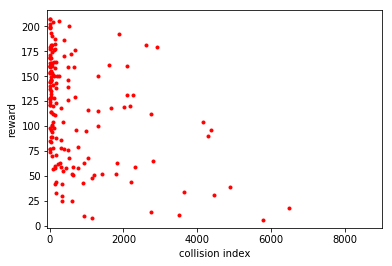

In [47]:
nn = n[n<216]
cc = collision[n<216]
fig, ax = plt.subplots(1, 1)
ax.set_xlim(-60, 9000)
ax.set_ylim(-2, 216)
ax.set_xlabel('collision index')
ax.set_ylabel('reward')
for i in range(nn.shape[0]):
    if cc[i] + 30* nn[i] > 1000 and cc[i] + 30* nn[i] < 9000 and cc[i]>5:
        ax.plot( cc[i], nn[i], marker='.', color=(1,0,0))

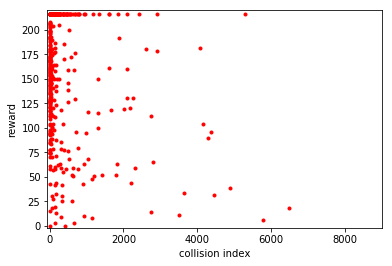

In [50]:
fig, ax = plt.subplots(1, 1)
ax.set_xlim(-60, 9000)
ax.set_ylim(-2, 220)
ax.set_xlabel('collision index')
ax.set_ylabel('reward')
for i in range(n.shape[0]):
    ax.plot( collision[i], n[i], marker='.', color=(1,0,0))

# Video processing, tactile data visualization

In [46]:
import numpy as np
def load_txt(path):
    file = open(path, 'r')
    result = []
    for line in file:
        result.append(line.rstrip())
    return result

def timestamp(time_txt):
    '''
    time text is in format hour:min:sec,millisec

    '''
    millisec = time_txt.split(',')[1]
    hour, minute, second = time_txt.split(',')[0].split(':')
    return float(hour) * 3600 + float(minute) * 60 + float(second) + float(millisec) * 1e-7

def add_timestamp(t0, dt):
    '''
    t0 in timestamp format
    dt is str with format: 'minute:second:microsec'
    return timestamp
    '''
    minute, second, microsec = dt.split(':')
    return t0 + float(minute)*60 + float(second) + float(microsec)*1e-7

def pose_str2list(str):
    pose = str.split(',')
    pose = [float(item) for item in pose]
    return pose

def extrat_force(txt):
    result = []
    for i, line in enumerate(txt):
        try:
            items = line.split()
            time = timestamp(items[2])
            fx = float(items[4])
            fy = float(items[5])
            fz = float(items[6])
            result.append([time, fx, fy, fz])
        except:
            print(i)
    return result

def filter_force(force, t0, t1):
    '''
    force: list of [timestamp, fx, fy, fz]
    t0, t1: timestamp of start and end time
    return: list of force within t0-t1
    '''
    result = [[] for i in range(3)]
    for item in force:
        time = item[0]
        if time > t0 and time < t1:
            result[0].append(item[1])
            result[1].append(item[2])
            result[2].append(item[3])
    return result


# Force data extraction
force_path = '/home/jc/logs/iros_video/log1.txt'
force_txt = load_txt(force_path)
force = extrat_force(force_txt)

# sort force based on action timestamp
t0 = force[0][0]

right_start = add_timestamp(t0, '01:23:25000')
right_end = add_timestamp(right_start, '00:10:3000')

left_start = add_timestamp(t0, '01:33:010000')
left_end = add_timestamp(left_start, '00:10:25000')

up_start = add_timestamp(t0, '01:39:7000')
up_end = add_timestamp(up_start, '00:10:6000')

# extrat force data for 3 actions 
force_right = filter_force(force, right_start, right_end)
force_left = filter_force(force, left_start, left_end)
force_up = filter_force(force, up_start, up_end)


In [47]:
print(force_txt[1])
print(force[1])
print(t0, right_start, right_end, left_start, left_end, up_start, up_end)
print(len(force_right[0]), len(force_left[0]),len(force_up[0]))

time: 2/24 13:45:36,723421  force:    -0.000     0.000     0.000
[49536.0723421, -0.0, 0.0, 0.0]
49536.0633235 49619.0658235 49629.0661235 49629.064323499995 49639.0668235 49635.064023499996 49645.064623499995
104 104 104


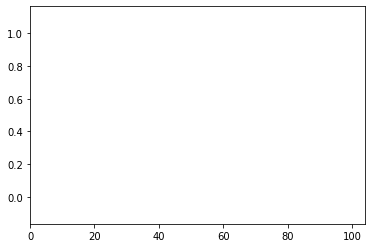

In [49]:
# plot force and do animation
import matplotlib.pyplot as plt
plt.ion()
fig, axe = plt.subplots(1,1)
axe.set_xlim(0, len(force_right[0]))
for i in range(len(force_right[0])):
    axe.plot(force_right[0][:i], 'r')
    axe.plot(force_right[1][:i], 'g')
    axe.plot(force_right[2][:i], 'b')
    plt.pause(0.01)
    

In [6]:
import numpy as np
import pickle
normalizer = pickle.load(open('/home/jc/logs/tactile_normalizer.pickle', 'rb'))

In [7]:
# 0-24 gripper xpos 
# 24-204 touch
# 204 234 tendon
normalizer['max'] = np.ones(234)
normalizer['max'][:6] = 6
normalizer['max'][24:204] = 800
normalizer['max'][204:] = 6

normalizer['min'] = -np.ones(234)
normalizer['min'][:6] = -6
normalizer['min'][24:204] = -800
normalizer['min'][204:] = -0.01

In [9]:
# pickle.dump(normalizer, open('/home/jc/logs/multistep_normalizer.pickle', 'wb'))


In [16]:
normalizer['min'][366:]

array([-0.0001, -0.0001, -0.0001, -0.0001, -0.0001, -0.0001, -0.0001,
       -0.0001, -0.0001, -0.0001, -0.0001, -0.0001, -0.0001, -0.0001,
       -0.0001, -0.0001, -0.0001, -0.0001, -0.0001, -0.0001, -0.0001,
       -0.0001, -0.0001, -0.0001, -0.0001, -0.0001, -0.0001, -0.0001,
       -0.0001, -0.0001])

# extract and organize data for tactile state estimation network training


In [8]:
import pickle
import random
import csv
import os
import numpy as np

sample_ratio = 0.4
timelaps = 10
root_dir = '/home/jc/logs/tactile_state_estimation_traj'

def extract_data(traj):
    tactile_data = []
    for step in traj:
        tactile_data.append(step['tactile'])
    fl_norm = traj[-1]['norm'][:3]
    break_dir_norm = traj[-1]['norm'][6:9]
    return np.stack(tactile_data), np.hstack([fl_norm, break_dir_norm])



In [9]:
all_traj = pickle.load(open('/home/jc/logs/tactile_state_estimation_traj/traj_0724_train.pickle', 'rb'))
print('Total trajectory numbers: ',len(all_traj))



csv_path = os.path.join(root_dir, 'train.csv')
csvfile = open(csv_path, 'w')                    
csv_writer = csv.writer(csvfile, delimiter=',')

for k, expert_traj in enumerate(all_traj):
    print(len(expert_traj))
    for i in range(timelaps, len(expert_traj)):
        sample = random.random()
        if sample < sample_ratio:
            data, label = extract_data(expert_traj[i-timelaps:i])
            
            data_path = os.path.join(root_dir, 'tactile',
                                     'data_{}_{}.pkl'.format(k,i))
            pickle.dump(data, open(data_path, 'wb'))

            label_path = os.path.join(root_dir, 'labels', 
                                      'label_{}_{}.pkl'.format(k,i))
            pickle.dump(label, open(label_path, 'wb'))
            csv_writer.writerow(['data_{}_{}.pkl'.format(k,i) , 
                                 'label_{}_{}.pkl'.format(k,i)])

csvfile.close()

Total trajectory numbers:  300
55
60
107
64
42
64
57
47
70
69
47
84
54
55
78
47
45
61
35
68
49
112
67
50
48
73
56
70
50
47
68
40
78
68
52
86
69
77
56
77
43
62
45
86
70
67
79
48
90
53
81
46
63
73
64
64
50
67
73
96
111
54
64
59
75
73
99
66
66
51
54
79
62
59
46
99
40
60
90
44
59
54
41
66
71
72
47
90
51
105
35
62
50
99
66
63
81
34
49
56
88
72
62
91
42
54
48
95
74
43
37
83
72
69
62
86
76
37
85
54
64
55
114
56
86
4
57
63
58
71
26
73
61
50
50
71
77
54
49
61
60
103
65
59
54
78
49
71
55
87
74
80
80
66
57
40
30
34
70
57
53
65
86
50
42
86
103
39
60
57
66
54
63
50
67
85
91
39
62
96
68
45
48
62
78
73
46
97
68
41
42
84
81
49
56
113
53
59
43
63
54
83
61
47
72
60
60
63
41
52
106
52
93
81
66
64
72
93
63
62
47
64
36
53
44
87
83
72
65
58
53
49
102
59
65
50
58
36
53
66
62
25
50
65
52
48
51
63
108
48
90
41
45
66
58
98
71
62
40
59
92
77
117
63
80
90
81
60
95
53
61
68
50
40
74
83
64
52
62
63
78
50
72
74
39
58
67
34
72
96
89
59
62
73
52
77
63
71
54
63
